# REPLICATION: DATA ANALYSIS

As mentioned in the README.md, the replication phase of this project aims at studying the influence of several variability factors of the original experiment. We selected two of them:
- LLM: we used a other model, Llama, to generate 100 games against Stockfish. We will evaluate its ability to play legal moves and compare its strength to the other LLMs, using the same ELO rating computing method.
- Variant: we made ChatGPT 3.5 turbo-instruct and Llama play Chess960 against Stockfish, to see if it is able to notice it and play accordingly (in the PGN headers), and at which level of strength.

In [3]:
import chess 
import chess.pgn
import glob
import pandas as pd
import os 
import re 
import matplotlib.pyplot as plt
from jupyterChessPGN import JupyterChessPGN
import numpy as np

In [32]:
def compute_score(df, model_name='gpt-3.5-turbo-instruct', percentage=True):
    # Count the number of wins, losses, and draws for gpt-3.5-turbo-instruct
      
    wins_as_white = df[(df['white'] == model_name) & (df['result'] == '1-0')].shape[0]
    wins_as_black = df[(df['black'] == model_name) & (df['result'] == '0-1')].shape[0]
    losses_as_white = df[(df['white'] == model_name) & (df['result'] == '0-1')].shape[0]
    losses_as_black = df[(df['black'] == model_name) & (df['result'] == '1-0')].shape[0]
    draws_as_white = df[(df['white'] == model_name) & (df['result'] == '1/2-1/2')].shape[0]
    draws_as_black = df[(df['black'] == model_name) & (df['result'] == '1/2-1/2')].shape[0]

    # Calculate total wins, losses, and draws
    total_wins = wins_as_white + wins_as_black
    total_losses = losses_as_white + losses_as_black
    total_draws = draws_as_white + draws_as_black

    if percentage:
        return (total_wins + (total_draws * 0.5)) / (total_wins + total_losses + total_draws)
    else:
        return (total_wins + (total_draws * 0.5), total_wins + total_losses + total_draws)


In [33]:
def display_game(game_folder: str):
    jc = JupyterChessPGN(os.path.join(game_folder, "game.pgn")) 
    jc.make_gamelist_menu()
    # first game of PGN file to init 
    jc.set_ith_game(0)
    jc.showUI()

In [ ]:
# To load data from an existing dataframe:
# df = pd.read_csv("analysis_files/games_replication_db.csv")

# Store the games in a pandas dataframe

In [44]:
# If you are using the notebook manually: set the correct folder in the default_folder variable
# If the notebook is used for automatic html generation by docker: infer it from the GPTCHESS_GAMES_FILE environment variable

default_folder = "games_replication"

games_compressed_file = os.getenv("GPTCHESS_GAMES_FILE")

if games_compressed_file is None:
    games_folder = default_folder
else:
    games_folder = os.path.join(os.getenv("WORKDIR"),
                                os.path.basename(games_compressed_file).split(".")[0]
                               )
    
print(f"Folder used: {games_folder}")

Folder used: games_replication


### Retrieve information from each game

In [45]:
# list each folder of folder "games"
# get all folders
folders = glob.glob(games_folder + "/*")

# sort folders by date
folders.sort(key=os.path.getmtime)

df = pd.DataFrame(columns=["white", "black", "white_elo", "black_elo", "result", "nmoves", "nstarting_move", "pgn_base", "temperature", "random_engine", "has_illegal", "illegal_move", "folder_name"])

for folder in folders:

    # for each folder:
    # read PGN file "game.pgn"

    # check that "game.pgn" exists
    if not os.path.exists(folder + "/game.pgn"):
        print("No game.pgn in " + folder) # TODO
        continue

    with open(folder + "/game.pgn") as pgn:
        game = chess.pgn.read_game(pgn)

    # read metainformation.txt
    # get the GPT model and the engine (SF or random)
    nmove_value = None
    with open(folder + "/metainformation.txt") as f:
        lines = f.readlines()

    # Iterate over each line in the file
    for line in lines:
        # Check if the line contains the string 'nmove:'
        if 'nmove:' in line:
            # Split the line at 'nmove:' and take the second part
            # Then strip leading and trailing whitespaces and convert to integer
            nmove_value = int(line.split('nmove:')[1].strip())
            # Print the extracted value
            break
    
    if nmove_value is None:
        nmove_value = 1 # default value

    # number of moves
    game_length = len(list(game.mainline_moves()))

    # for each PGN:
    # get the GPT model and the engine (SF or random)
    white = game.headers["White"]
    black = game.headers["Black"]

    # get the Elo of the player (if any)
    white_elo = game.headers["WhiteElo"]
    black_elo = game.headers["BlackElo"]

    # get the result (or infer based on checkmates) # special case: no mate, or unifinished game due to wrong move
    result = game.headers["Result"]

    has_illegal = False
    illegal_move = ''
    # check that UnknownSAN key is in game
    # if not, continue
    if 'UnknownSAN' in game.headers:
        has_illegal = True
        illegal_move = game.headers["UnknownSAN"]
        # print("warning: UnknownSAN in game")
        # continue

    with open(folder + "/metainformation.txt") as file:
        content = file.read()

    # find the content between 'temperature:' and ends of line
    match_random = re.search(r'random_engine:([\s\S]+?)(\n)', content, re.MULTILINE)
    random_engine = None
    if match_random:
        random_engine = match_random.group(1).strip()
        if 'True' in random_engine:
            random_engine = True
        elif 'False' in random_engine:
            random_engine = False
        else:   
            print("random engine value unclear/unknwon")
                
    else:
        random_engine = False
        # print('No random engine found') # default value: False (note: should not happen)

    with open(folder + "/metainformation.txt") as file:
        content = file.read()

    # find the content between 'temperature:' and ends of line
    match_temperature = re.search(r'temperature:([\s\S]+?)(\n)', content, re.MULTILINE)
    temperature = None
    if match_temperature:
        temperature = match_temperature.group(1).strip()
        # print(extracted_content)
    else:
        temperature = 0.0
        # print('No temperature found') # default value: 0

    with open(folder + "/metainformation.txt") as file:
        content = file.read()

    # Find the content between 'base_pgn:' and another term at the start of a new line followed by ':'
    match = re.search(r'base_pgn:([\s\S]+?)(^\w+:)', content, re.MULTILINE)
    pgn_base = ''
    if match:
        # Extract and clean up the matched content
        pgn_base = match.group(1).strip()
        # print(extracted_content)
    else:
        print('No base pgn found')

    # put in dfframe
    # columns: white, black, white_elo, black_elo, result
    # append to dataframe

    game_data = pd.DataFrame([{"white": white, "black": black, "white_elo": white_elo, "black_elo": black_elo,
                         "result": result, "nmoves" : game_length, "nstarting_move": nmove_value, "pgn_base" : pgn_base,
                         "temperature" : temperature, "random_engine" : random_engine, "has_illegal" : has_illegal,
                         "illegal_move" : illegal_move, "folder_name" : folder}])
    df = pd.concat([df, game_data], ignore_index=True) if len(df) > 0 else game_data


    # compute stats
    # scores in general, per Elo and chess engine, per GPT model
    # ability to finish a game (with weaker models)

    # first: Elo = 1700, GPT=3.5 instruct
    # second: Elo = 1800, GPT=3.5 instruct
    # ...



No game.pgn in games_replication/game3b0d71b8-8de8-4edd-96a2-3548553a571c
No game.pgn in games_replication/game55bb41e2-bf34-4fa0-8d39-f1c7c3b67462
No game.pgn in games_replication/game217533d1-622c-4944-bac1-1ac9393c8078
No game.pgn in games_replication/game2426f9ce-1ec7-43df-ba15-bca95a43fd75
No game.pgn in games_replication/gamec7c433e1-711c-4ad4-ae94-994c4796a21d
No game.pgn in games_replication/gameb4d70a3b-032a-4039-aca2-e6c4b27fc274
No game.pgn in games_replication/gamefc3b8135-1ea6-46b8-a6b5-242d7a83b97b
No game.pgn in games_replication/game7f49edac-fc6f-4040-89d0-33aeaa59f8fa
No game.pgn in games_replication/gameb8fa20db-b8c5-4eea-8347-5c649ea0ec24
No game.pgn in games_replication/gamefe42daad-5798-40e4-af82-330f117202c0
No game.pgn in games_replication/game8785e408-9c49-4b87-bf34-c2d687e056b8
No game.pgn in games_replication/game6272abfb-afd8-4fc4-894c-2106ca035047
No game.pgn in games_replication/gameb651ca4d-64f7-42a0-9bc6-7103101a783a
No game.pgn in games_replication/gamec

illegal san: 'O-O' in qrnnbkrb/pppppp1p/6p1/8/8/6P1/PPPPPP1P/QRNNBKRB w - - 0 2 while parsing <Game at 0x798c615897b0 ('Stockfish' vs. 'gpt-3.5-turbo-instruct', '????.??.??' at '?')>
illegal san: 'O-O' in qrnnbkrb/pppppppp/8/8/8/8/PPPPPPPP/QRNNBKRB w - - 0 1 while parsing <Game at 0x798c6158a680 ('Stockfish' vs. 'gpt-3.5-turbo-instruct', '????.??.??' at '?')>


In [46]:
import chess
import chess.pgn
import io 

# include a column indicating wether this is a normal chess game or chess960

def is960(pgn):
    g = chess.pgn.read_game(io.StringIO(pgn))
    return g.headers.is_chess960()

df["chess960"] = df["pgn_base"].apply(is960)

In [47]:
print(f"-> {len(df)}/{len(folders)} games retrieved")

-> 208/223 games retrieved


### Result

In [48]:
df.head()

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,chess960
0,Stockfish,gpt-3.5-turbo-instruct,1954,?,*,7,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Nc6,games_replication/game0a018ed3-fbfc-4d00-8460-...,True
1,Stockfish,gpt-3.5-turbo-instruct,1954,?,*,11,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Qxd4,games_replication/game7a75ff64-8bf2-44b8-a82b-...,True
2,Stockfish,gpt-3.5-turbo-instruct,1954,?,*,9,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Nf6,games_replication/game90832e60-aeb0-4558-b1e7-...,True
3,Stockfish,gpt-3.5-turbo-instruct,1954,?,*,1,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,1.,games_replication/game54e63739-7247-4a63-9c84-...,True
4,Stockfish,gpt-3.5-turbo-instruct,1954,?,*,11,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Bg4,games_replication/game1c4c3eb8-2b3f-4f89-ba17-...,True


In [49]:
# Frequencies based on piece colors
for variant in ("Normal", "Chess960"):
    chess960 = variant == "Chess960"
    
    df_variant = df[df["chess960"] == chess960]
    players = set(df_variant["white"].unique()).union(set(df_variant["black"].unique())).difference({"Stockfish"})
    color_breakdown = {}
    for player in players:
        white_count = df_variant[df_variant['white'] == player].shape[0]
        black_count = df_variant[df_variant['black'] == player].shape[0]
        color_breakdown[player] = {'white': white_count, 'black': black_count, 'total': white_count+black_count}

    print(f"- Variant {variant}:")
    print(pd.DataFrame(color_breakdown), "\n")

- Variant Normal:
       llama-3.3-70b-versatile  gpt-3.5-turbo-instruct
white                        0                       0
black                      100                       5
total                      100                       5 

- Variant Chess960:
       llama-3.3-70b-versatile  gpt-3.5-turbo-instruct
white                        0                       0
black                       90                      13
total                       90                      13 



In [50]:
df.to_csv(f"analysis_files/{os.path.basename(games_folder)}_db.csv")
print(f"Saved at analysis_files/{os.path.basename(games_folder)}_db.csv")

Saved at analysis_files/games_replication_db.csv


# Llama against Stockfish (normal chess): illegal moves and ELO

### Illegal moves analysis

In [68]:
def illegal_moves_analysis(df, model_name, filtering_rules=None):
    df = df.query(f"white == '{model_name}' or black == '{model_name}'")
    
    if filtering_rules is not None:
        print(f"ANALYSIS OF {model_name}, WITH '{filtering_rules}':")
        df = df.query(filtering_rules)
    else:
        print(f"ANALYSIS OF {model_name}:")

    # Games lengths
    print(f"- {len(df)} total games, with lengths:")
    (df['nmoves'] / 2).plot(kind='box')
    plt.show()

    # Score
    df_legal_games = df.query("has_illegal == False")
    if len(df_legal_games > 0):
        score = compute_score(df_legal_games, model_name=model_name)
        print(f"- Score {round(100*score, 2)}% for games with only legal moves")
    
    score, t = compute_score(df, model_name=model_name, percentage=False)
    tot = len(df)
    print(f"Score {round(100*(score/tot), 2)}% for all games i.e. {score}/{tot}, being legal or illegal (illegal move = loss)")

    # Number of illegal games & enum
    vals = df['has_illegal'].value_counts()
    ntot = vals.get(True, 0) + vals.get(False, 0)
    illegal_percentage = round((vals.get(True, 0)/ntot)*100) if ntot else 0
    print(f"- Out of {ntot} games, {vals.get(False, 0)} were legal games and {vals.get(True, 0)} were illegal games, hence {illegal_percentage}% of illegal games.")

    print("Illegal moves are:")
    print(df.query("has_illegal == True")['illegal_move'].value_counts().to_markdown())

ANALYSIS OF llama-3.3-70b-versatile, WITH 'chess960 == False':
- 100 total games, with lengths:


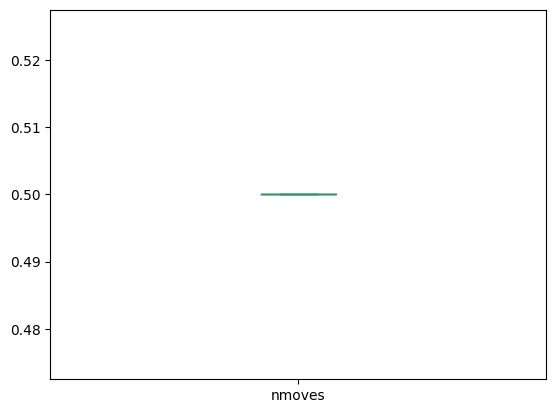

Score 0.0% for all games i.e. 0.0/100, being legal or illegal (illegal move = loss)
- Out of 100 games, 0 were legal games and 100 were illegal games, hence 100% of illegal games.
Illegal moves are:
| illegal_move   |   count |
|:---------------|--------:|
| A              |      57 |
| You've         |      20 |
| With           |      15 |
| It             |       7 |
| 1.             |       1 |


In [69]:
illegal_moves_analysis(df, "llama-3.3-70b-versatile", "chess960 == False")

## ELO rating

Pointless